<a href="https://colab.research.google.com/github/Ryukijano/DL_audio/blob/hf_audio_course/speech_to_speech_translation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Speech-to-speech translation (STST or S2ST) is a relatively new spoken language processing task. It involves translating speech from one langauge into speech in a different language:

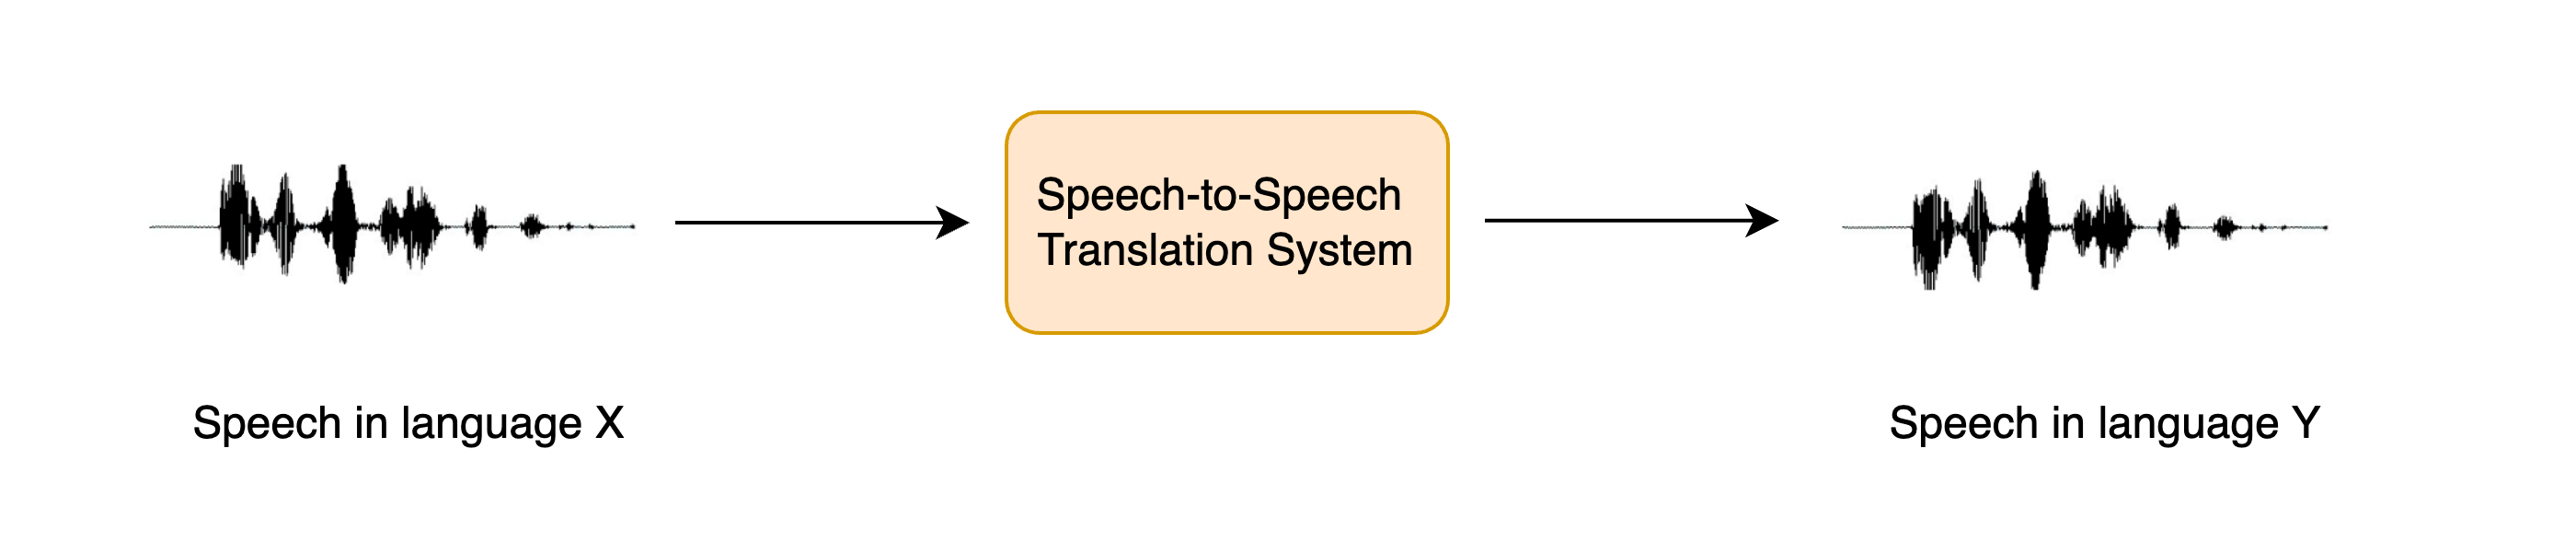

STST can be viewed as an extension of the traditional machine translation (MT) task: instead of translating text from one language into another, we translate speech from one language into another. STST holds applications in the field of multilingual communication, enabling speakers in different languages to communicate with one another through the medium of speech.

Suppose we want to communicate with another individual across a langauge barrier. Rather than writing the information that we would want to convey and then translating it to text in the target language, we can speak it directly and have a STST system convert your spoken speech into the target langauge. The recipient can then respond by speaking back at the STST system, and we can listen to their response. This is a more natural way of communicating compared to text-based machine translation.

Here explore a cascaded approach to STST. We’ll use a speech translation (ST) system to transcribe the source speech into text in the target language, then text-to-speech (TTS) to generate speech in the target language from the translated text:

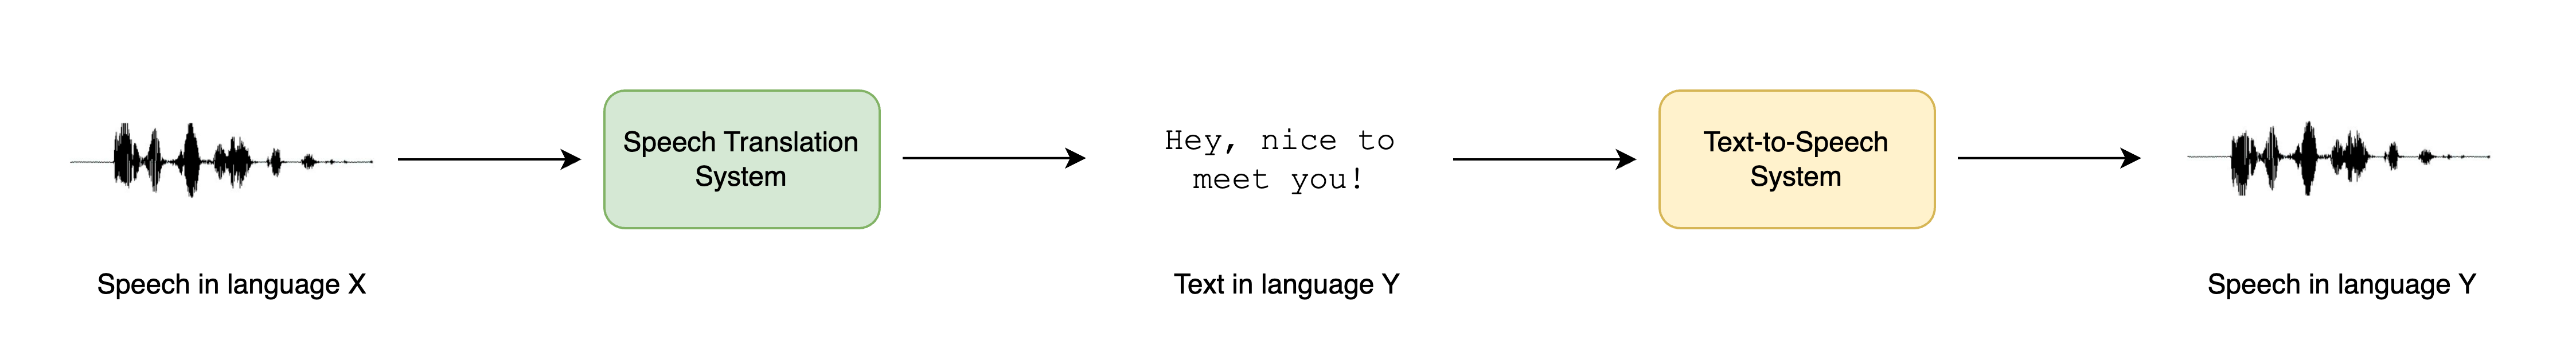

We could also have used a three stage approach, where first we use an automatic speech recognition (ASR) system to transcribe the source speech into text in the same language, then machine translation to translate the transcribed text into the target language, and finally text-to-speech to generate speech in the target language. However, adding more components to the pipeline lends itself to error propagation, where the errors introduced in one system are compounded as they flow through the remaining systems, and also increases latency, since inference has to be conducted for more models.

While this cascaded approach to STST is pretty straightforward, it results in very effective STST systems. The three-stage cascaded system of ASR + MT + TTS was previously used to power many commercial STST products, including Google Translate. It’s also a very data and compute efficient way of developing a STST system, since existing speech recognition and text-to-speech systems can be coupled together to yield a new STST model without any additional training.

In [1]:
pip install transformers

In [2]:
import torch
from transformers import pipeline

device = "cuda:0" if torch.cuda.is_available() else "cpu"
pipe = pipeline(
    "automatic-speech-recognition", model="openai/whisper-base", device=device
)

In [3]:
pip install datasets

###Speech Translation
We’ll use the Whisper model for our speech translation system, since it’s capable of translating from over 96 languages to English. Specifically, we’ll load the Whisper Base checkpoint, which clocks in at 74M parameters. It’s by no means the most performant Whisper model, with the largest Whisper checkpoint being over 20x larger, but since we’re concatenating two auto-regressive systems together (ST + TTS), we want to ensure each model can generate relatively quickly so that we get reasonable inference speed:

In [4]:
#loading an audio sample in italian language
from datasets import load_dataset

dataset = load_dataset("facebook/voxpopuli", "it", split="validation", streaming=True)
sample = next(iter(dataset))

In [5]:
#listening to it
from IPython.display import Audio

Audio(sample["audio"]["array"], rate=sample["audio"]["sampling_rate"])

In [13]:
'''defining a function that takes this audio input and returns the translated text. We have to pass the generation key-word argument for the "task", setting to "translate" to ensure that Whisper performs speech translation
and not speech recognition'''
def translate(audio):
    outputs = pipe(audio, max_new_tokens=256, generate_kwargs={"task": "translate"})
    return outputs["text"]

Whisper can also be ‘tricked’ into translating from speech in any language X to any language Y. Simply set the task to "transcribe" and the "language" to your target language in the generation key-word arguments, e.g. for Spanish, one would set:

generate_kwargs={"task": "transcribe", "language": "es"}

In [15]:
#checking result from the model
translate(sample["audio"].copy())

' psychological and social. I think that it is a very important step in the construction of a juridical space of freedom, circulation and protection of rights.'

In [8]:
#comparing to the source text
sample["raw_text"]

'Penso che questo sia un passo in avanti importante nella costruzione di uno spazio giuridico di libertà di circolazione e di protezione dei diritti per le persone in Europa.'

Setting the locale to UTF-8 from ANSI

In [9]:
!export LC_ALL=C.UTF-8
!export LANG=C.UTF-8


In [10]:
!pip install sentencepiece

Text-to-speechThe second half of our cascaded STST system involves mapping from English text to English speech. For this, we’ll use the pre-trained SpeechT5 TTS model for English TTS. 🤗 Transformers currently doesn’t have a TTS pipeline, so we’ll have to use the model directly ourselves. This is no biggie, you’re all experts on using the model for inference following Unit 6!

First, we  load the SpeechT5 processor, model and vocoder from the pre-trained checkpoint:


In [11]:
from transformers import SpeechT5Processor, SpeechT5ForTextToSpeech, SpeechT5HifiGan

processor = SpeechT5Processor.from_pretrained("microsoft/speecht5_tts")

model = SpeechT5ForTextToSpeech.from_pretrained("microsoft/speecht5_tts")
vocoder = SpeechT5HifiGan.from_pretrained("microsoft/speecht5_hifigan")

Here we're using SpeechT5 checkpoint trained specifically for English TTS. Should you wish to translate into a language other than English, either swap the checkpoint for a SpeechT5 TTS model fine-tuned on your language of choice, or use an MMS TTS checkpoint pre-trained in your target langauge.

In [12]:
model.to(device)
vocoder.to(device)

SpeechT5HifiGan(
  (conv_pre): Conv1d(80, 512, kernel_size=(7,), stride=(1,), padding=(3,))
  (upsampler): ModuleList(
    (0): ConvTranspose1d(512, 256, kernel_size=(8,), stride=(4,), padding=(2,))
    (1): ConvTranspose1d(256, 128, kernel_size=(8,), stride=(4,), padding=(2,))
    (2): ConvTranspose1d(128, 64, kernel_size=(8,), stride=(4,), padding=(2,))
    (3): ConvTranspose1d(64, 32, kernel_size=(8,), stride=(4,), padding=(2,))
  )
  (resblocks): ModuleList(
    (0): HifiGanResidualBlock(
      (convs1): ModuleList(
        (0): Conv1d(256, 256, kernel_size=(3,), stride=(1,), padding=(1,))
        (1): Conv1d(256, 256, kernel_size=(3,), stride=(1,), padding=(3,), dilation=(3,))
        (2): Conv1d(256, 256, kernel_size=(3,), stride=(1,), padding=(5,), dilation=(5,))
      )
      (convs2): ModuleList(
        (0-2): 3 x Conv1d(256, 256, kernel_size=(3,), stride=(1,), padding=(1,))
      )
    )
    (1): HifiGanResidualBlock(
      (convs1): ModuleList(
        (0): Conv1d(256, 256,

In [16]:
#loading up embeddings
embeddings_dataset = load_dataset("Matthijs/cmu-arctic-xvectors", split="validation")
speaker_embeddings = torch.tensor(embeddings_dataset[7306]["xvector"]).unsqueeze(0)

Generating validation split: 0 examples [00:00, ? examples/s]

Dataset cmu-arctic-xvectors downloaded and prepared to /root/.cache/huggingface/datasets/Matthijs___cmu-arctic-xvectors/default/0.0.1/a62fea1f9415e240301ea0042ffad2a3aadf4d1caa7f9a8d9512d631723e781f. Subsequent calls will reuse this data.


We can now write a function that takes a text prompt as input, and generates the corresponding speech. We’ll first pre-process the text input using the SpeechT5 processor, tokenizing the text to get our input ids. We’ll then pass the input ids and speaker embeddings to the SpeechT5 model, placing each on the accelerator device if available. Finally, we’ll return the generated speech, bringing it back to the CPU so that we can play it back in our ipynb notebook:

In [18]:
def synthesise(text):
    inputs = processor(text=text, return_tensors="pt")
    speech = model.generate_speech(
        inputs["input_ids"].to(device), speaker_embeddings.to(device), vocoder=vocoder
    )
    return speech.cpu()

In [19]:
#checking with dummy text
speech = synthesise("Hey there! This is a test!")

Audio(speech, rate=16000)

Creating a STST demo

Before we create a Gradio demo to showcase our STST system, let’s first do a quick sanity check to make sure we can concatenate the two models, putting an audio sample in and getting an audio sample out. We’ll do this by concatenating the two functions we defined in the previous two sub-sections, such that we input the source audio and retrieve the translated text, then synthesise the translated text to get the translated speech. Finally, we’ll convert the synthesised speech to an int16 array, which is the output audio file format expected by Gradio. To do this, we first have to normalise the audio array by the dynamic range of the target dtype (int16), and then convert from the default NumPy dtype (float64) to the target dtype (int16):


In [20]:
import numpy as np

target_dtype = np.int16
max_range = np.iinfo(target_dtype).max


def speech_to_speech_translation(audio):
    translated_text = translate(audio)
    synthesised_speech = synthesise(translated_text)
    synthesised_speech = (synthesised_speech.numpy() * max_range).astype(np.int16)
    return 16000, synthesised_speech

In [21]:
#checking results from this concatenated function
sampling_rate, synthesised_speech = speech_to_speech_translation(sample["audio"])

Audio(synthesised_speech, rate=sampling_rate)

In [24]:
!pip install gradio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.8/19.8 MB 39.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.7/65.7 kB 7.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 288.8/288.8 kB 26.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.4/75.4 kB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.5/50.5 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.7/138.7 kB 14.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.7/45.7 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.6/59.6 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 14.2 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of mdit-py-plugins to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 5.2 MB/s eta 0:00:00
   

In [25]:
#wrapping up a gradio demo
import gradio as gr

demo = gr.Blocks()

mic_translate = gr.Interface(
    fn=speech_to_speech_translation,
    inputs=gr.Audio(source="microphone", type="filepath"),
    outputs=gr.Audio(label="Generated Speech", type="numpy"),
)

file_translate = gr.Interface(
    fn=speech_to_speech_translation,
    inputs=gr.Audio(source="upload", type="filepath"),
    outputs=gr.Audio(label="Generated Speech", type="numpy"),
)

with demo:
    gr.TabbedInterface([mic_translate, file_translate], ["Microphone", "Audio File"])

demo.launch(debug=True)

/usr/local/lib/python3.10/dist-packages/gradio/blocks.py:934: UserWarning: api_name predict already exists, using predict_1
  warnings.warn(


Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
Note: opening Chrome Inspector may crash demo inside Colab notebooks.

To create a public link, set `share=True` in `launch()`.


<IPython.core.display.Javascript object>

Keyboard interruption in main thread... closing server.
